## Задание 4. Найти выбросы

#### Описание задачи:

В этом датасете – выборка из значений величины трафика на одной из российских дорог. В переменной **volume** находится истинное количество транспортных средств, зарегистрированное на определенном километре в определенное время, а в **volume_calc** – это же количество минус количество транспортных средств, чье местоположение по тем или иным причинам разглашать нельзя.

Для соревнования по прогнозированию ДТП в датасете необходимо было оставить только “публичную” переменную **volume_calc**, однако в тех случаях, когда разрыв между **volume** и **volume_calc** аномально велик, эта переменная не информативна для ML-модели. Поэтому было решено оставить лишь информативные значения **volume_calc**, а прочие заменить на пропуски.

Предложите стратегию, какие значения **volume_calc** стоит заменить на пропуски. *Подсказка: при построении моделей машинного обучения количественные переменные обычно нормализуются, поэтому любая переменная там может быть представлена с точностью до линейного преобразования.*

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

matplotlib.style.use('seaborn')
%matplotlib inline

In [2]:
# Чтение данных
df = pd.read_csv('traffic_sample.csv')
df.head()

,volume,volume_calc
0,12.0,10.0
1,234.0,230.0
2,26.0,26.0
3,20.0,16.0
4,42.0,42.0


### Шаг 1

Изучим разницу между переменными volume и volume_calc: посмотрим описательные статистики, определим наличие выбросов и их характер. Избавимся от явных экстремальных выбросов

In [3]:
# Общая информация по датасету, проверка пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   volume       100000 non-null  float64
 1   volume_calc  100000 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


In [4]:
# Считаем разницу (дельту) между volume и volume_calc, выводим описательные статистики этой разницы
df['delta'] = df['volume'] - df['volume_calc']
df.delta.describe()

count    100000.000000
mean          6.558090
std         165.283642
min        -235.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       21374.000000
Name: delta, dtype: float64

### Первые выводы: 

* Большинство значений дельта сосредоточено на 0: первый и третий квартили равны нулю
* Имеются сильные выбросы вправо (max = 21 374), которые, однако, не сильно искажают среднее значение
* В дельте оказались минусовые значения: это, должно быть, ошибка, так как по условиям задачи volume_calc не может быть меньше значения volume

In [5]:
# Количество минусовых значений дельты
len(df[df.delta < 0])

21

In [6]:
# Таких значений немного, к тому же их отклонение от 0 невелико относительно выбросов справа.
# Поэтому эти значения можно прираванять к нулю

# ПРИМЕЧАНИЕ. Эти значения можно также заменить на NaN'ы. Их немного, поэтому они не должны искажать результаты,
# какую бы стратегию мы не выбрали: приравнять к 0 или заменить NaN'ами

# Приравняем в этих строках значения volume и volume_calc
df.volume_calc = np.where(df.delta < 0, df.volume, df.volume_calc)

# Пересчитываем дельту
df['delta'] = df['volume'] - df['volume_calc']

# Проверяем количество минусовых значений
len(df[df.delta < 0])

0

In [7]:
# Посмотрим на долю значений, где volume отличается от volume_calc (то есть дельта не равна 0)
len(df[df.delta != 0]) / len(df)

0.22917

In [8]:
# Таких значений всего 23%

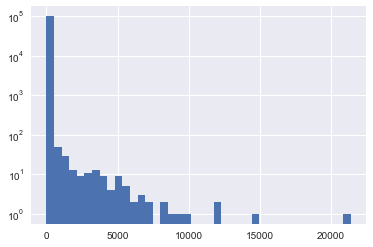

In [9]:
# Посмотрим на распределение переменной дельта на гистограмме, прологарифмировав по шкале y для наглядности
plt.hist(df.delta, log=True, bins=40);

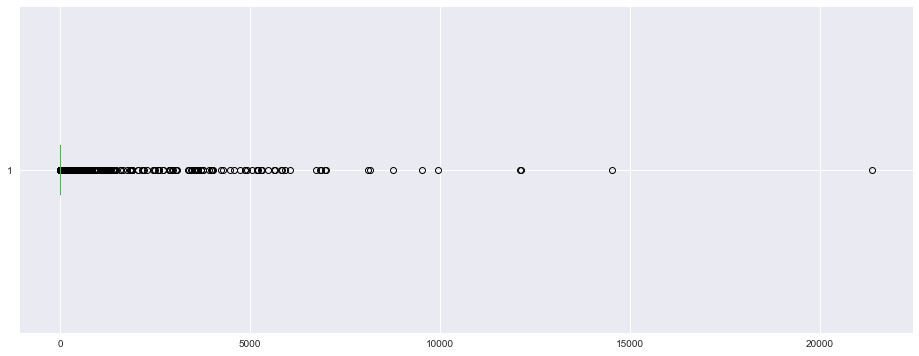

In [10]:
# также распределение по ящику с усами
fig, ax = plt.subplots(figsize=(16,6))
ax.boxplot(df.delta, vert=False);

### Промежуточные выводы:

Наблюдаются отдельно стоящие экстремальные выбросы справа, от которых можно избавиться, так как они потенциально могут сильно исказить результат предсказаний модели.

В качестве "коридора" для фильтрации экстремальных выбросов используем три значения стандартного отклонения

In [11]:
# Рассчет трех сигм и округление до целых, так как переменная - количество автомобилей
three_sigma = round(3 * df.delta.std())
three_sigma

496

In [12]:
# Количество таких выбросов
len(df[df.delta > three_sigma])

176

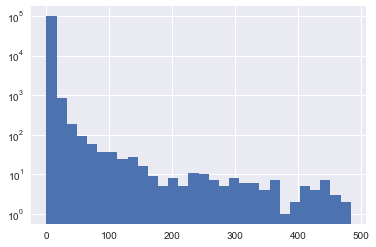

In [13]:
# Таких выбросов немного относительно размера датасета. Убираем эти 176 выбросов (заменяем значения в строках 
# на NaN)
df.loc[df['delta'] > three_sigma, :] = np.nan

# Гистограмма распределения после избавления от экстремальных выбросов
plt.hist(df.delta, log=True, bins=30);

In [14]:
# Посмотрим еще раз на описательные статистики дельты
df.delta.describe()

count    99824.000000
mean         1.751573
std         12.080254
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        484.000000
Name: delta, dtype: float64

### Промежуточные выводы:

Распределение дельты стало лучше: среднее значение приблизилось к медиане, а стандартное отклонение значительно снизилось. Однако для улучшения результата можно воспользоваться нормализацией

### Шаг 2

Нормализуем переменную delta при помощи линейного преобразования: сократим "коридор" от минимального до максимального значения в 5 раз. После преобразования дельта будет иметь значение о 0 до 100. После этого определим новые выбросы.

*Примечание* С размером "коридора" можно поэкспериментировать в зависимости от того, какой результат будет выдавать модель. Возможно, уменьшение/увеличение коридора будет как-то влиять на качество модели.

In [15]:
# Применяем нормализацию из библиотеки sklearn
df['delta_norm'] = MinMaxScaler(feature_range=(0,100)).fit_transform(np.array(df.delta).reshape(-1,1))
df.head()

,volume,volume_calc,delta,delta_norm
0,12.0,10.0,2.0,0.413223
1,234.0,230.0,4.0,0.826446
2,26.0,26.0,0.0,0.000000
3,20.0,16.0,4.0,0.826446
4,42.0,42.0,0.0,0.000000


In [16]:
# Округлим значения нормализованной дельты до целых чисел, так как речь в задаче идет об автомобилях

# ПРИМЕЧАНИЕ. Здесь снова, на мой взгляд, надо смотреть на результаты модели. Возможно, округлять стоит не 
# на этом шаге, а на более поздних этапах. Можно было бы попробовать обучить модель на разных данных и посмотреть 
# на метрики качества

df['delta_norm_round'] = np.round(df.delta_norm)
df.head()

,volume,volume_calc,delta,delta_norm,delta_norm_round
0,12.0,10.0,2.0,0.413223,0.0
1,234.0,230.0,4.0,0.826446,1.0
2,26.0,26.0,0.0,0.000000,0.0
3,20.0,16.0,4.0,0.826446,1.0
4,42.0,42.0,0.0,0.000000,0.0


In [17]:
# Описательные статистики получившейся дельты
df.delta_norm_round.describe()

count    99824.000000
mean         0.324241
std          2.498133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: delta_norm_round, dtype: float64

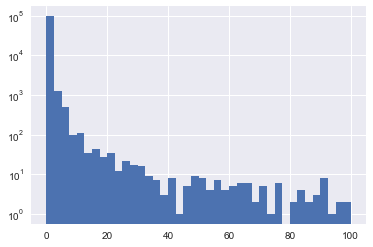

In [18]:
# Гистограмма распределения
plt.hist(df.delta_norm_round, log=True, bins=40);

In [19]:
# В районах значения дельты 80 образовалась устойчивая "яма", которая сохраняется при разном количестве столбцов 
# гистограммы (bins). Эти значения также можно трактовать как выбросы, так как "яма" говорит о том, что эти выбросы
# достаточно сильно отличаются от основного распределения

# Количество значений правее "ямы"
len(df[df.delta_norm_round >= 80])

24

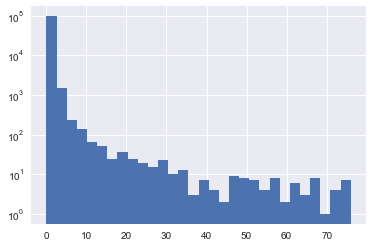

In [20]:
# Убираем эти 24 выброса (заменяем значения в строках на NaN)
df.loc[df['delta_norm_round'] >= 80, :] = np.nan

# Гистограмма распределения после избавления от экстремальных выбросов
plt.hist(df.delta_norm_round, log=True, bins=30);

In [21]:
# Снова описательные статистики дельты
df.delta_norm_round.describe()

count    99800.000000
mean         0.302886
std          2.082951
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         76.000000
Name: delta_norm_round, dtype: float64

### Промежуточные выводы:

Среднее значение теперь очень близко к медиане, а стандартное отклонение всего 2

### Шаг 3

Создадим новую переменную - исправленную volume_calc, которая представляет собой volume минус нормализованное значение дельты. Таким образом, разница между реальным количеством автомобилей и тем, на котором должна учиться модель, станет минимальным

In [22]:
df['volume_calc_norm'] = df.volume - df.delta_norm_round
df.head()

,volume,volume_calc,delta,delta_norm,delta_norm_round,volume_calc_norm
0,12.0,10.0,2.0,0.413223,0.0,12.0
1,234.0,230.0,4.0,0.826446,1.0,233.0
2,26.0,26.0,0.0,0.000000,0.0,26.0
3,20.0,16.0,4.0,0.826446,1.0,19.0
4,42.0,42.0,0.0,0.000000,0.0,42.0


### Общие выводы

Таким образом, мы отобрали 99 800 значений из 100 000 исходных, пригодных для обучения модели. На первом шаге мы избавились от минусовых значений разницы межды volume и volume_calc, так как таких значений не должно быть по условиям задачи. Далее мы убрали экстремальные выбросы справа: те значения, которые превышают три стандартных отклонения. Затем мы применили нормализацию и поместили все значения разницы-дельты в "коридор" от 0 до 100, после чего убрали экстремальные выбросы, которые получились после нормализации. Наконец, задали новую переменную volume_calc_norm, которая представляет собой volume минус нормализованная дельта. Эту новую переменную можно использовать для обучения модели.

При этом необходимо понимать, что в вопросе определения выбросов не может быть идеального решения. Многое зависит от результатов обучения непосредственно самой модели и получившихся метрик качества модели. Поэтому на каждом шаге возможны другие тактики: можно увеличить / уменьшить размер "коридора" при нормализации, проводить округление до целых самой дельты, или переменной volume_calc_norm, или обучать модель на дробных значениях и т.д.